In [ ]:
using SparseArrays
using LinearAlgebra
using NLopt
using PyPlot
using KrylovKit
using Statistics
using FiniteDifferences
using IJulia
using Revise
using TopologyOptimizationHelper

Precompiling TopologyOptimizationHelper


We will optimize a cavity in one dimension using successive refinement.

In [ ]:
# Our favorite parameters for testing
# Re-run to randomize
L = 5
res = 50
ε = ones(res * (L + 4))
M = length(ε) 
ω = 2π
_, x = Maxwell1d(L, ε, ω; resolution=res);

b = zeros(M)
b[M÷2] = 1;

The actual optimum is a quarter-wave stack that alternates between $\varepsilon = 1$ and $\varepsilon = 12$, as shown below.

Suppose $\left(\omega_k^2, u_k\right)$ is the eigenpair of $-\varepsilon^{-1}(x)(\nabla^2 + \omega^2 \mathrm{Id})$ that minimizes $|\omega - \omega_k|.$ Denote this value by $\omega_0(\varepsilon)$.

In [ ]:
custom_epsilon = Fabry_Perot_epsilon.(L, x; λ=1)
plot(x, custom_epsilon)
xlabel("Horizontal Position")
ylabel("ε Values")

@show custom_ω₀ = Maxwell_omega(L, custom_epsilon, ω, b; resolution=res)
@show Q_custom = -real(custom_ω₀) / 2imag(custom_ω₀);

Given an initial guess of $\varepsilon_{\text{init}}(x) = 1$ everywhere, we run our old optimizer for at most 100 iterations to get $\varepsilon_{\text{opt}}$. The computed eigenvalue $\omega_0(\varepsilon_{\text{opt}})$ and quality factor $Q$ for the output and a plot of its structure are shown below.

In [4]:
LDOS_opt, ε_opt, LDOS_vals, x = LDOS_Optimize(L, ε, ω, b; resolution=res, ftol=0, max_eval=50)
@show ω₀ = Maxwell_omega(L, ε_opt, ω, b; resolution=res)
@show Q = -real(ω₀) / 2imag(ω₀);

numevals = opt.numevals = 50
ω₀ = Maxwell_omega(L, ε_opt, ω, b; resolution = res) = 6.2837955578275455 - 0.021446060024808446im
Q = -(real(ω₀)) / (2 * imag(ω₀)) = 146.5023307441683


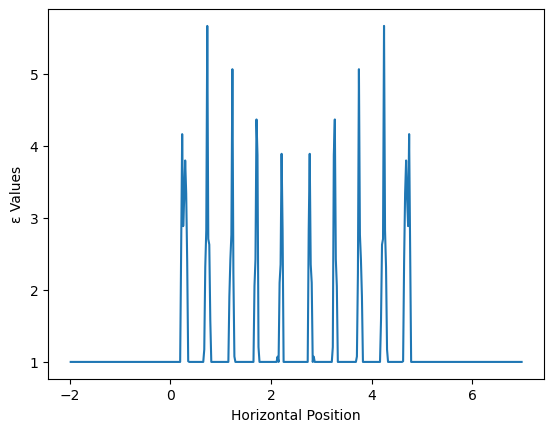

PyObject Text(24.000000000000007, 0.5, 'ε Values')

In [5]:
plot(x, ε_opt)
xlabel("Horizontal Position")
ylabel("ε Values")

The structure does not resemble the quarter-wave stack, and running the old optimization for several thousand iterations is inefficient, so let us change up our strategy. We will now shift the eigenvalue, attempting to close the gap between $\omega_0$ and $\omega$ directly. This new optimizer takes $\varepsilon_{\text{opt}}$ as an argument and gives us a more optimal $\varepsilon_{\text{best}}$.

In [6]:
mod_LDOS_opt, mod_ε_opt, mod_LDOS_vals, omegas, x = mod_LDOS_Optimize(L, ε_opt, ω, b, b; resolution=res, max_eval=50)

real(ω₀) - ω = 0.0006102506479592762
real(ω₀) - ω = 0.0006284794098414537
CCSA dual converged in 20 iters to g=-0.0779672:
    CCSA y[0]=0.418254, gc[0]=-3.12898e-011
real(ω₀) - ω = 0.003940495243042186
CCSA outer iteration: rho -> 0.1
                 CCSA rhoc[0] -> 0.1
CCSA dual converged in 17 iters to g=-0.086394:
    CCSA y[0]=0.545915, gc[0]=2.23062e-010
real(ω₀) - ω = 0.030997211478644537
CCSA outer iteration: rho -> 0.01
                 CCSA rhoc[0] -> 0.01
                 CCSA sigma[0] -> 0
CCSA dual converged in 18 iters to g=-0.18079:
    CCSA y[0]=0.841674, gc[0]=2.16685e-009
real(ω₀) - ω = -0.00970117487190958
CCSA outer iteration: rho -> 0.001
                 CCSA rhoc[0] -> 0.001
                 CCSA sigma[0] -> 0
CCSA dual converged in 22 iters to g=-0.921849:
    CCSA y[0]=3.96233, gc[0]=3.09842e-009
real(ω₀) - ω = 0.0017755389803841837
CCSA inner iteration: rho -> 0.001
                CCSA rhoc[0] -> 0.00232893
CCSA dual converged in 16 iters to g=-0.878671:
   

(200.69538154393243, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.07681229667910863, 0.07862452397377145, 0.09195420679173018, 0.32711525639661154, 5.028819360418973, 4.085604798975705, 16.300276659669386, 27.741120213060782, 33.21633392365343, 39.74930734900521  …  158.42250057401228, 160.49074963808386, 160.29819544166688, 166.97220464509869, 166.91538206260864, 186.32087981783687, 186.27354212033836, 200.73194795826714, 200.69538154393243, 208.4625099162935], ComplexF64[6.2837955578275455 - 0.021446060024808446im, 6.283813786589428 - 0.021044850890703144im, 6.287125802422628 - 0.0184343223396699im, 6.314182518658231 - 0.00528991310692506im, 6.273484132307677 - 0.0004991769216615597im, 6.28496084615997 - 0.0006003330386565742im, 6.286025185441 - 0.00015601311441945222im, 6.2842087858259115 - 9.101941052968152e-5im, 6.2832176671804065 - 7.625611573560736e-5im, 6.2826416575229045 - 6.821102828334911e-5im  …  6.2831874449541

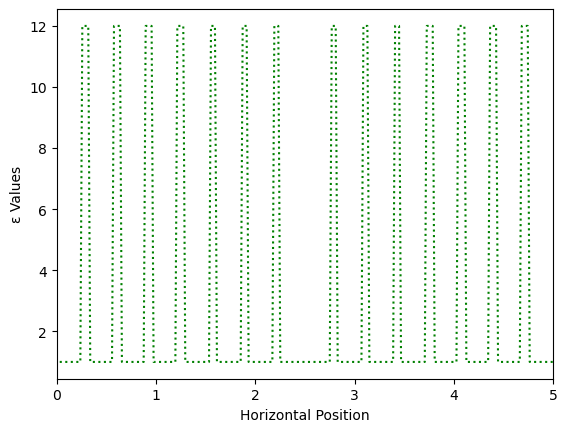

(0.0, 5.0)

In [4]:
#plot(x, mod_ε_opt, "b-")
plot(x, custom_epsilon,"g:")
# plot(x, best_ε_opt, "r-")
xlabel("Horizontal Position")
ylabel("ε Values")
xlim(0, 5)

In just 50 iterations, we now have a structure $\varepsilon_{\text{best}}$ with $Q \sim 10^5$. If we instead choose to do successive refinement and gradually increase the volume of the design region, we can get much better $Q$ values.

In [8]:
function succ_ref(L, L₀, ε_init, ω, b, x₀; resolution=res, max_eval=50, step=1, ftol=1e-4)
    _, ε, LDOS_vals, x =  LDOS_Optimize(L, ε_init, ω, b; resolution, ftol=0, max_eval, design_width=L₀)
    _, mod_ε_opt, mod_LDOS_vals, omegas, _ = mod_LDOS_Optimize(L, ε, ω, b, x₀; resolution, max_eval, design_width=L₀ + step, ftol)
    append!(LDOS_vals, mod_LDOS_vals)

    n = 2
    while L₀ + n * step < L
        LDOS, mod_ε_opt, mod_LDOS_vals, new_omegas, _ = mod_LDOS_Optimize(L, mod_ε_opt, ω, b, x₀; resolution, max_eval, design_width=L₀ + n * step, ftol)
        append!(LDOS_vals, mod_LDOS_vals)
        append!(omegas, new_omegas)
        n += 1
    end

    return mod_ε_opt, LDOS_vals, omegas
end

succ_ref (generic function with 1 method)

In [9]:
best_ε_opt, all_LDOS_vals, all_omegas = succ_ref(L, 1, ε, ω, b, b; resolution=res, max_eval=50, step=0.50)

numevals = opt.numevals = 50
real(ω₀) - ω = -0.003369177746781915
real(ω₀) - ω = -4.952941114222398e-5
CCSA dual converged in 96 iters to g=-0.0193686:
    CCSA y[0]=0.0193504, gc[0]=-3.42414e-010
real(ω₀) - ω = 0.00014776331192578596
CCSA - using infeasible point?
CCSA inner iteration: rho -> 1
                CCSA rhoc[0] -> 1.29422
CCSA dual converged in 104 iters to g=-0.0199172:
    CCSA y[0]=0.0023258, gc[0]=3.67312e-009
real(ω₀) - ω = -0.008529935898877739
CCSA outer iteration: rho -> 0.1
                 CCSA rhoc[0] -> 0.129422
CCSA dual converged in 19 iters to g=-0.0228741:
    CCSA y[0]=0.00238166, gc[0]=3.36975e-009
real(ω₀) - ω = 0.00020435114546213384
CCSA inner iteration: rho -> 0.1
                CCSA rhoc[0] -> 0.491927
CCSA dual converged in 19 iters to g=-0.0228465:
    CCSA y[0]=0.00448392, gc[0]=3.88997e-009
real(ω₀) - ω = -0.041146204250053664
CCSA outer iteration: rho -> 0.01
                 CCSA rhoc[0] -> 0.0491927
                 CCSA sigma[0] -> 0
CCSA du

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0015911521589114504, 0.001594937337413718, 0.0016330569521584809, 0.0022043743546437426, 0.0012636625183382883, 0.0024507488473107975, 0.005104058018319087, 0.0073800168038133055, 0.002268135104499105, 0.0130829734538831  …  54232.74783703787, 58726.21203928942, 57425.802723155604, 58706.03953445357, 59415.3699805529, 59508.44479473114, 59668.440226238876, 59861.38301230458, 60024.44404687592, 60028.77350492976], ComplexF64[6.279816129432804 - 0.2623261962096553im, 6.283135777768444 - 0.253852933609653im, 6.283333070491512 - 0.2457625333295888im, 6.2746553712807085 - 0.1826766152244059im, 6.283389658325048 - 0.1835069799704273im, 6.242039102929533 - 0.06676426447491127im, 6.257825475012977 - 0.06372533296752286im, 6.271132450555539 - 0.06363927519837141im, 6.279475615001523 - 0.06426473171240296im, 6.2847158249531985 - 0.06519042088292022im  …  6.328614835740148 - 8.263620972598

In [10]:
A_opt, _ = Maxwell1d(L, best_ε_opt, ω; resolution=res)
@show ω₀_opt = sqrt(Arnoldi_eig(A_opt, best_ε_opt, ω, b)[1])
Q_opt = -real(ω₀_opt) / 2imag(ω₀_opt)

ω₀_opt = sqrt((Arnoldi_eig(A_opt, best_ε_opt, ω, b))[1]) = 6.283186595705627 - 7.464870445796322e-8im


4.20850344378305e7

We now have $Q \sim 10^7$ (the same as the quarter-wave stack) and our structure resembles the quarter-wave stack.

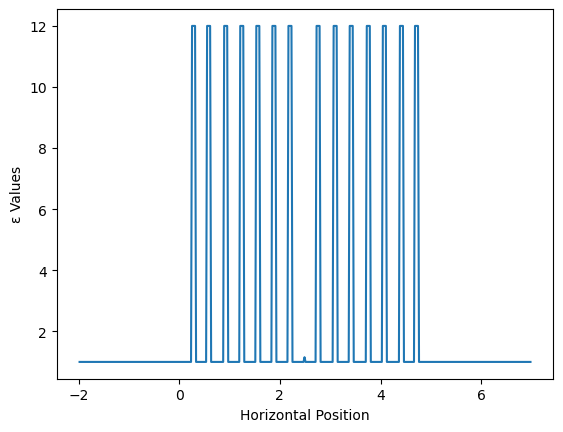

PyObject Text(24.000000000000007, 0.5, 'ε Values')

In [11]:
plot(x, best_ε_opt)
xlabel("Horizontal Position")
ylabel("ε Values")

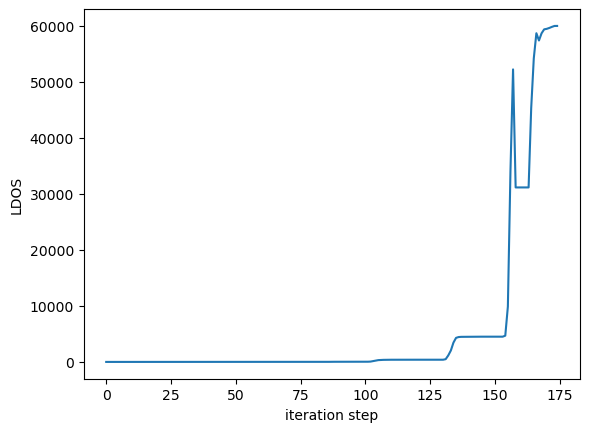

PyObject Text(24.0, 0.5, 'LDOS')

In [12]:
plot(all_LDOS_vals)
xlabel("iteration step")
ylabel("LDOS")

The eigenvector should be very localized at the center of the design region, with exponential decay as we approach the boundaries.

In [13]:
# The eigenpair (ω₀, u₀) solves [E⁻¹A(ω) + ω²I]u₀ = ω₀²u₀
E⁻¹ = spdiagm(1 ./ best_ε_opt)
A, x = Maxwell1d(L, best_ε_opt, ω; resolution=res)
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, b, 1, EigSorter(λ -> abs(λ - ω^2); rev = false), Arnoldi()) 
u₀ = vecs[1];

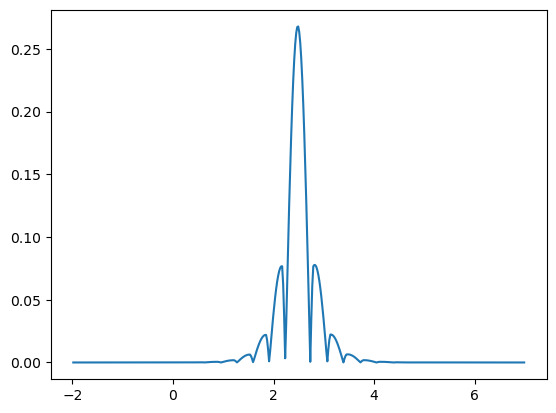

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000238497FD540>

In [14]:
v = abs.(u₀)
plot(x, v)